<a href="https://colab.research.google.com/github/prateekmarda/prateekmarda/blob/main/RNN_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simple RNN project on IMDB sentiment classification (Keras/TensorFlow).
Save as simple_rnn_imdb.py and run after installing the required packages.



In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow / Keras imports
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
# -------------------------
# 1) Load dataset
# -------------------------
# Keep only the top `num_words` most frequent words to limit vocabulary size
num_words = 10000
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)

print(f"Loaded IMDB dataset: {len(x_train)} training samples, {len(x_test)} test samples")



17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Loaded IMDB dataset: 25000 training samples, 25000 test samples


We only want the 10,000 most common words from the dataset.

* IMDB dataset contains many rare words that appear very few times.
* Keeping only frequent words helps:
* reduce memory usage
* reduce training time
* reduce noise from rare words

Example

If a word appears only once, it's not useful.
So IMDB replaces those rare words with a special token (<UNK>).

In [3]:
# -------------------------
# 2) Inspect a sample
# -------------------------
print("\nExample token indices for first training sample (first 20 tokens):")
print(x_train[0][:20])
print("Label (0 negative, 1 positive):", y_train[0])




Example token indices for first training sample (first 20 tokens):
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25]
Label (0 negative, 1 positive): 1


In [4]:
# -------------------------
# 3) Decode a review (optional, for intuition)
# -------------------------
# Keras provides a word_index mapping (word -> index). We'll invert it to decode.
word_index = keras.datasets.imdb.get_word_index()
# Keras reserves indices 0-3 for special tokens, so we shift existing indices by 3
index_to_word = {index + 3: word for word, index in word_index.items()}
index_to_word[0] = "<PAD>"
index_to_word[1] = "<START>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

def decode_review(token_list):
    """Convert token indices back into a readable string (approximate)."""
    return " ".join(index_to_word.get(i, "?") for i in token_list)

print("\nDecoded first review (truncated):")
print(decode_review(x_train[0])[:400], "...")



1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Decoded first review (truncated):
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it ...


In [5]:
# -------------------------
# 4) Preprocess: pad sequences
# -------------------------
# RNNs (and most Keras layers) expect inputs shaped (batch, time_steps).
# We'll pad (or truncate) every review to `maxlen` tokens.
maxlen = 200
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen, padding='post', truncating='post')
x_test  = keras.preprocessing.sequence.pad_sequences(x_test,  maxlen=maxlen, padding='post', truncating='post')

print("\nAfter padding:")
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)




After padding:
x_train shape: (25000, 200)
x_test shape: (25000, 200)


In [9]:
# -------------------------
# 5) Build the RNN model
# -------------------------
# - Embedding layer turns word indices into dense vectors of size embedding_dim
# - SimpleRNN consumes the sequence (can capture short-term dependencies)
# - Dense(1, sigmoid) outputs probability for positive sentiment
embedding_dim = 32
rnn_units = 32

model = keras.Sequential([
    layers.Embedding(input_dim = num_words, output_dim = embedding_dim, input_length = maxlen, name = "embedding"),
    layers.SimpleRNN(rnn_units, name = "simple_rnn"),
    layers.Dense(1, activation = "sigmoid", name = "output")
], name = "simple_rnn_imdb")

model.summary()



Model: "simple_rnn_imdb"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
# -------------------------
# 6) Compile the model
# -------------------------
model.compile(
    optimizer = "adam",               # Adam optimizer is a good default
    loss = "binary_crossentropy",     # binary labels, so binary crossentropy
    metrics = ["accuracy"]            # track accuracy
)



In [11]:
# -------------------------
# 7) Train
# -------------------------
# We'll use a validation split to have quick feedback on generalization.
epochs = 10            # small for demo; increase to 5-10 for better results
batch_size = 128

history = model.fit(
    x_train, y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_split = 0.2,
    verbose = 2
)



Epoch 1/10
157/157 - 13s - 83ms/step - accuracy: 0.5089 - loss: 0.6952 - val_accuracy: 0.5116 - val_loss: 0.6932
Epoch 2/10
157/157 - 9s - 58ms/step - accuracy: 0.5970 - loss: 0.6633 - val_accuracy: 0.5026 - val_loss: 0.7005
Epoch 3/10
157/157 - 10s - 64ms/step - accuracy: 0.6747 - loss: 0.5708 - val_accuracy: 0.5114 - val_loss: 0.7501
Epoch 4/10
157/157 - 10s - 65ms/step - accuracy: 0.7549 - loss: 0.4338 - val_accuracy: 0.5152 - val_loss: 0.8276
Epoch 5/10
157/157 - 10s - 63ms/step - accuracy: 0.8043 - loss: 0.3586 - val_accuracy: 0.5000 - val_loss: 0.9516
Epoch 6/10
157/157 - 9s - 56ms/step - accuracy: 0.8277 - loss: 0.3225 - val_accuracy: 0.5204 - val_loss: 0.9273
Epoch 7/10
157/157 - 11s - 69ms/step - accuracy: 0.8640 - loss: 0.2811 - val_accuracy: 0.5088 - val_loss: 1.0350
Epoch 8/10
157/157 - 10s - 66ms/step - accuracy: 0.8940 - loss: 0.2348 - val_accuracy: 0.5104 - val_loss: 1.1422
Epoch 9/10
157/157 - 10s - 63ms/step - accuracy: 0.9215 - loss: 0.1862 - val_accuracy: 0.5030 - va

In [12]:
# -------------------------
# 8) Evaluate on test set
# -------------------------
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"\nTest accuracy: {test_acc:.4f}  Test loss: {test_loss:.4f}")


782/782 - 9s - 11ms/step - accuracy: 0.5069 - loss: 1.2033

Test accuracy: 0.5069  Test loss: 1.2033


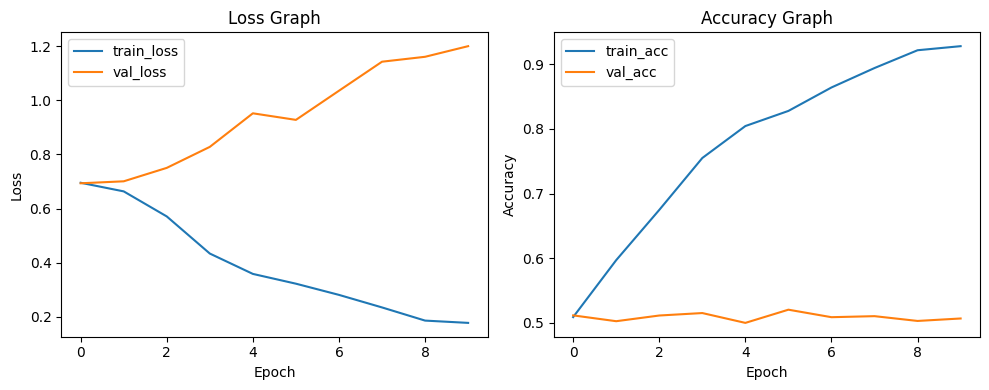

In [14]:
# -------------------------
# 9) Plot training curves
# -------------------------
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Graph")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_accuracy"], label = "val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy Graph")
plt.legend()

plt.tight_layout()
plt.show()



In [15]:
# -------------------------
# 10) Predict on a few test samples and display results
# -------------------------
n_show = 5
preds = model.predict(x_test[:n_show])
pred_labels = (preds > 0.5).astype(int).flatten()

rows = []
for i in range(n_show):
    snippet = decode_review(x_test[:i+1][-1])[:250].replace("\n"," ")
    rows.append({
        "snippet": snippet,
        "true_label": int(y_test[i]),
        "pred_prob": float(preds[i]),
        "pred_label": int(pred_labels[i])
    })

df = pd.DataFrame(rows)
print("\nSample predictions:")
print(df.to_string(index=False))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step

Sample predictions:
                                                                                                                                                                                                                                                   snippet  true_label  pred_prob  pred_label
<START> please give this one a miss br br <UNK> <UNK> and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this was           0   0.577844           1
<START> this film requires a lot of patience because it focuses on mood and character development the plot is very simple and many of the scenes take place on the same set in frances <UNK> the sandy dennis character apartment but the film builds to a           1   0.181618           0
<START> many animation buffs consider <UNK> <UNK> the great forgotten genius of on

/tmp/ipython-input-3415232359.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "pred_prob": float(preds[i]),


In [16]:
# -------------------------
# 11) Save model (optional)
# -------------------------
model.export("simple_rnn_imdb_model")
print("\nModel saved as 'simple_rnn_imdb_model' in current directory.")


Saved artifact at 'simple_rnn_imdb_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138926087053840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138926087055568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138926087058256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138926087055376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138926087057872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138926087058832: TensorSpec(shape=(), dtype=tf.resource, name=None)

Model saved as 'simple_rnn_imdb_model' in current directory.
